## RIVERS-PILOT EXPERIMENT OVERVIEW

    The rivers-pilot project runs the realistic SSC, v201812 (good bloom timing), from the following run directory:
        SS-run-sets/SalishSea/nemo3.6/tereza/RIVERS/RIVERS_pilot
        
    Restarts are from /results/SalishSea/nowcast-green.201812/31dec16
    
    There are two run scenarios, base and SHIFT, which use identical namelist.times and have the following diff patterns per yamls (base v SHIFT):
                < run_id: RP_base_1
            ---
            > run_id: RP_base_1_SHIFT
            20c20
            <     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_R201702/
            ---
            >     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_45Dearly/
            54c54
            <   - ./namelist.atmos_rivers
            ---
            >   - ./namelist.atmos_riversSHIFT
            
    The RIVERS_files are made in: 
        notebooks/RIVER_PAPER/RIVERS_pilot/make_daily_files and make_daily_files_shifted_hydrograph
    These use daily interpolated values from monthly averages, for all rivers except the fraser, where realistic 2017 values are used. 
    
    Then we shift the 'glacial' watersheds, as well as the Fraser river, forward 45 days to examine effects. 
        (not the rest of the fraser watershed; this is because Tereza forgot. 
        Not really a problem though, for a pilot run)
    The glacial watersheds are: wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    
    Results are stored in: /data/tjarniko/results/RIV_PIL
    
## NOTEBOOK OVERVIEW

    

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import sys
import numpy as np
import netCDF4 as nc
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import arrow
import gsw
import glob
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')

import river_201702 as rv

In [3]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']


wshed_tot = np.zeros([10,365])
i = 0 

for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        depth = rv.prop_dict[w][r]['depth']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]*river_dj*river_di
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        wshed_tot[i,:] = wshed_tot[i,:] + clim_dict[w][r]['interp_clim'][:]
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        

        
        if ((w == 'fraser') & (r == 'Fraser')):
            print(river_dj*river_di*depth)
            #print(clim_dict[w][r])
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim'] = hydroFraser_2017real /1000 * area 
#             print(clim_dict[w][r]['interp_clim'])
#             clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
        wshed_tot[i,:] = wshed_tot[i,:] + clim_dict[w][r]['interp_clim'][:]
            
    i = i+1
            
            
            

3


In [4]:
def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):
    "TESTED"

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 14 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
#     ax.set_xlabel('x Index', fontsize = 20 )
#     ax.set_ylabel('y Index', fontsize = 20 )
    

    watersheds = rv.prop_dict.keys()
    #watershed counter
    wc = 0
    tr = 0
    wsl = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
    wsl = ['Howe', 'Juan de Fuca', 'Puget', 'Skagit', 'Fraser (greater area)', 'North Vancouver Island', 
              'Jervis', 'Toba', 'Bute', 'South Vancouver Island']
    for watshed in watersheds:
        #print(watshed)
        rivs = rv.prop_dict[watshed].keys()
        #river counter for index
        rc = 0
        for riv in rivs:

            ti = rv.prop_dict[watshed][riv]['i']
            tj = rv.prop_dict[watshed][riv]['j']
            if (tj == 298):
                print(tj)
            if ((rc==0) & (tj!=298)): 
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],label = wsl[wc],marker='o')
                
            if ((rc!=0) & (tj!=298)):
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
                
            #ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 10)
            
#             samprivs = ['SanJuan', 'Skagit1', 'Puyallup', 'Nanaimo1', 'Homathko', 'Toba', 'Squamish', 'Englishman'] #samprivs = []
#             if riv in samprivs:
#                 ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 14)


            if ((rc!=0) & (tj!=298)):
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
            if riv == 'Homathko':
                #ax.text(tj+20,ti-20,riv, weight = 'bold', fontsize = 10)
                pts = ax.scatter(tj-3,ti-10,s=200,c=cols[wc],marker='*')
                ax.text(tj-250,ti-30,'Homathko nearshore station', weight = 'bold')
                print(f'Homathko {tj}, {ti}')
            if riv == 'Squamish':
                #ax.text(tj+-50,ti-25,riv, weight = 'bold', fontsize = 10)
                pts = ax.scatter(tj-5,ti-5,s=200,c=cols[wc],marker='*')
                ax.text(tj-250,ti-30,'Squamish nearshore station', weight = 'bold')
                print(f'Squampton {tj}, {ti}')

            rc = rc+1
            tr = tr+1
        wc = wc+1
    
    ax.scatter(380,415,s=30,c='orange',label = 'Fraser',marker='o')
    ax.scatter(300,425,s=200,c='orange',marker='*')
    ax.text(180,400,'Fraser nearshore station', weight = 'bold')   
    print(f'Fraser {180}, {400}')

    plt.xlim([0,390])
    plt.ylim([0,898])
    
    plt.xticks([])
    plt.yticks([])
    cmap.set_bad('white')
    plt.legend(bbox_to_anchor=(1.05, 1), ncol = 3, fontsize = 10)
    plt.suptitle(bigtit,fontsize=9)

In [6]:

watersheds = rv.prop_dict.keys()
riv_i = []
riv_j = []
riv_shed = []
riv_name = []
i = 0
for watshed in watersheds:
    #print('~~')
    rivs = rv.prop_dict[watshed].keys()
    for riv in rivs:
        print('Riv: '+riv+', watershed: '+watshed)
        #swap is, js here
        ti = rv.prop_dict[watshed][riv]['j']
        tj = rv.prop_dict[watshed][riv]['i']
        print(tj)
        riv_i.append(ti)
        riv_j.append(tj)
        riv_shed.append(watshed)
        riv_name.append(riv)
        i = i+1


gauge_riv = ['Squamish','SanJuan','Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene',\
            'Duckabush','Skokomish','DeerJohnsGoldboroughMill','Deschutes','Chambers',\
            'Chambers','NisquallyMcAllister','Puyallup','CedarSammamish','Skagit1',\
            'Samish','Stillaguamish1','SnohomishAllenQuilceda','Tulalip','Mission',\
            'Nooksack','Fraser','Oyster','Qunisam','SalmonSayward','Theodosia',
             'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman',
             'LittleQualicum','Puntledge']

cols = ['darkgray','red','chocolate','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

Riv: Squamish, watershed: howe
534
Riv: Burrard, watershed: howe
457
Riv: SanJuan, watershed: jdf
401
Riv: Gordon, watershed: jdf
404
Riv: Loss, watershed: jdf
376
Riv: Jordan, watershed: jdf
349
Riv: Muir, watershed: jdf
327
Riv: Tugwell, watershed: jdf
325
Riv: Sooke, watershed: jdf
316
Riv: Elwha, watershed: jdf
261
Riv: Tumwater, watershed: jdf
248
Riv: Valley, watershed: jdf
247
Riv: Ennis, watershed: jdf
244
Riv: Morse, watershed: jdf
240
Riv: Bagley, watershed: jdf
239
Riv: Siebert, watershed: jdf
235
Riv: McDonald, watershed: jdf
233
Riv: DungenessMatriotti, watershed: jdf
232
Riv: Coville, watershed: jdf
263
Riv: Salt, watershed: jdf
275
Riv: Field, watershed: jdf
281
Riv: Lyre, watershed: jdf
283
Riv: EastWestTwin, watershed: jdf
293
Riv: Deep, watershed: jdf
299
Riv: Pysht, watershed: jdf
311
Riv: Clallom, watershed: jdf
333
Riv: Hoko, watershed: jdf
346
Riv: Sekiu, watershed: jdf
349
Riv: Sail, watershed: jdf
373
Riv: Johnson, watershed: puget
208
Riv: Jimmycomelately, wate

# Rivers in the SKOG model

Squampton 384, 534
Homathko 293, 896
Fraser 180, 400


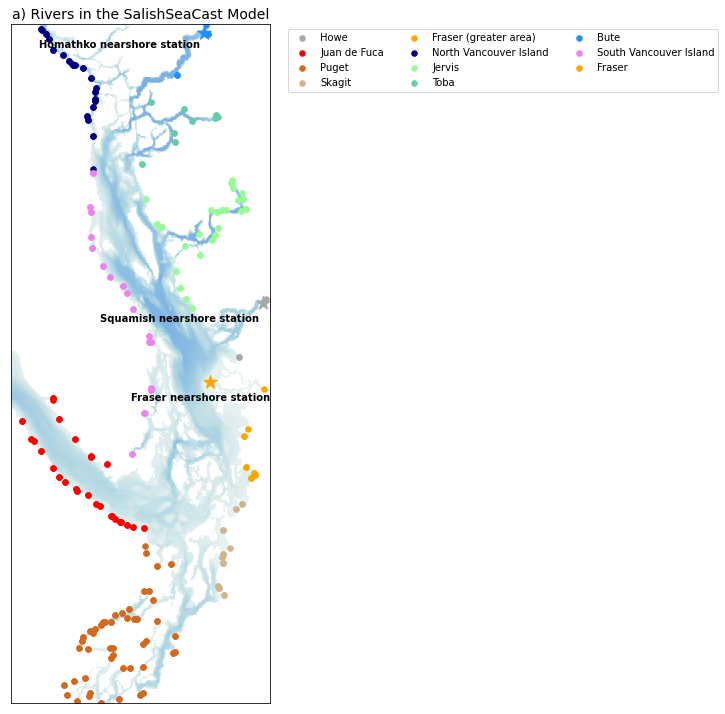

In [7]:
fact = 0.5
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']
wshed_plot(bath1,'a) Rivers in the SalishSeaCast Model', \
               cm.cm.dense,15*fact,25*fact,0,1500,'bathymetry','')

### calculate runoffs

In [7]:
rv.prop_dict['bute']

{'Homathko': {'prop': 0.58, 'i': 896, 'j': 293, 'di': 1, 'dj': 3, 'depth': 2},
 'Southgate': {'prop': 0.35, 'i': 885, 'j': 297, 'di': 1, 'dj': 1, 'depth': 1},
 'Orford': {'prop': 0.07, 'i': 830, 'j': 250, 'di': 1, 'dj': 1, 'depth': 1}}

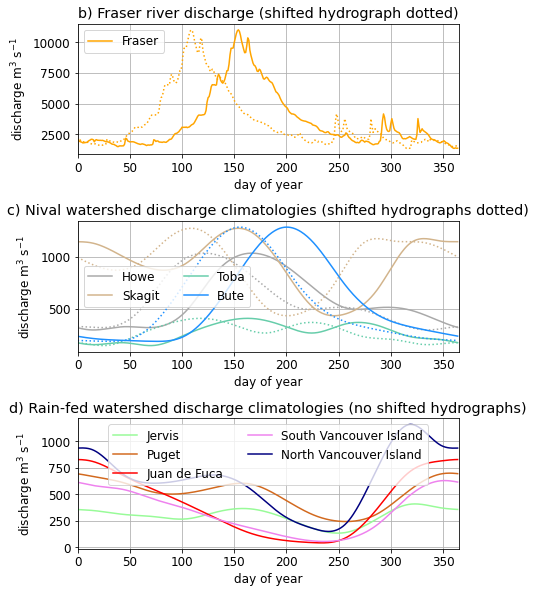

In [8]:
cols = ['darkgray','red','chocolate','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
wsl = ['Howe', 'Juan de Fuca', 'Puget', 'Skagit', 'Fraser', 'North Vancouver Island', 
          'Jervis', 'Toba', 'Bute', 'South Vancouver Island']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']


plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}
# i = 0 
# for w in watersheds:
#     interp_clim = climatology_file[w][:]
#     plt.plot(interp_clim, color = cols[i], label = wsl[i])
#     i = i+1
fact = 0.6
fig, axs = plt.subplots(3,1, figsize=(11*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

wat_to_rot = ['skagit', 'howe', 'bute', 'toba']

ftot = (np.sum(clim_dict['fraser']['Fraser']['interp_clim']))
howe = np.sum(climatology_file['howe'])
skagit = np.sum(climatology_file['skagit'])
toba = np.sum(climatology_file['toba'])
bute = np.sum(climatology_file['bute'])
jervis = np.sum(climatology_file['jervis'])
puget = np.sum(climatology_file['puget'])
jdf = np.sum(climatology_file['jdf'])
evi_s = np.sum(climatology_file['evi_s'])
evi_n = np.sum(climatology_file['evi_n'])

axs[0].plot(clim_dict['fraser']['Fraser']['interp_clim'], color = 'orange', label = 'Fraser')
axs[0].plot(np.roll(clim_dict['fraser']['Fraser']['interp_clim'],-45), color = 'orange', linestyle = ':')

axs[1].plot(climatology_file['howe'], color = 'darkgray', label = 'Howe')
axs[1].plot(np.roll(climatology_file['howe'],-45), color = 'darkgray', linestyle = ':')

axs[1].plot(climatology_file['skagit'], color = 'tan', label = 'Skagit')
axs[1].plot(np.roll(climatology_file['skagit'],-45), color = 'tan', linestyle = ':')

axs[1].plot(climatology_file['toba'], color = 'mediumaquamarine', label = 'Toba')
axs[1].plot(np.roll(climatology_file['toba'],-45), color = 'mediumaquamarine', linestyle = ':')

axs[1].plot(climatology_file['bute'], color = 'dodgerblue', label = 'Bute')
axs[1].plot(np.roll(climatology_file['bute'],-45), color = 'dodgerblue', linestyle = ':')

axs[2].plot(climatology_file['jervis'], color = 'palegreen', label = 'Jervis')

axs[2].plot(climatology_file['puget'], color = 'chocolate', label = 'Puget')

axs[2].plot(climatology_file['jdf'], color = 'red', label = 'Juan de Fuca')
axs[2].plot(climatology_file['evi_s'], color = 'violet', label = 'South Vancouver Island')
axs[2].plot(climatology_file['evi_n'], color = 'navy', label = 'North Vancouver Island')

for i in range(0,3):
    axs[0].legend(ncol = 2, loc = 'upper left')
    axs[1].legend(ncol = 2, loc = 'center left')
    axs[2].legend(ncol = 2, loc = 'upper center')
    axs[i].grid(); axs[i].set_xlim([0,365]); 
    axs[i].set_xlabel('day of year'); axs[i].set_ylabel('discharge m$^{3}$ s$^{-1}$')
    axs[0].set_title('b) Fraser river discharge (shifted hydrograph dotted)')
    axs[1].set_title('c) Nival watershed discharge climatologies (shifted hydrographs dotted)')
    axs[2].set_title('d) Rain-fed watershed discharge climatologies (no shifted hydrographs)')
plt.tight_layout()

In [9]:
ftot = (np.sum(clim_dict['fraser']['Fraser']['interp_clim']))
howe = np.sum(climatology_file['howe'])
skagit = np.sum(climatology_file['skagit'])
toba = np.sum(climatology_file['toba'])
bute = np.sum(climatology_file['bute'])
jervis = np.sum(climatology_file['jervis'])
puget = np.sum(climatology_file['puget'])
jdf = np.sum(climatology_file['jdf'])
evi_s = np.sum(climatology_file['evi_s'])
evi_n = np.sum(climatology_file['evi_n'])


print(ftot/(howe+skagit+ftot+toba+bute+jervis+puget+jdf+evi_s+evi_n))

0.4373653820770607


In [10]:
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  
print(hydroFraser_2017real)

[ 9.55215168  9.39541531  9.05779266  8.92258549  8.76297379  8.49901962
  8.53303432  8.5934391   8.69672203  8.7056427   9.11464024  9.3988533
  9.6020174   9.89330673  9.87539673  9.72811031  8.90996933  9.54213524
  9.74946117  9.53669643  9.49463654  9.47874069  9.49273396  9.43864918
  9.48834419  9.3222065   9.1968174   8.97386456  8.93473148  8.89896393
  8.75536537  8.56257629  8.30117416  8.0375433   7.95771837  7.90142965
  7.62128735  7.43994141  7.10637331  7.09283304  7.33263206  7.36041451
  7.33150816  7.37497234  7.38241053  8.02158642 10.28025436 10.07755089
  9.25828934  9.0977459   8.90155315  8.9283886   8.9476366   8.93771744
  8.85554504  8.67111778  8.50928497  8.27352428  8.15457439  8.06725216
  7.90258026  8.05221272  8.13897514  8.01873493  7.89574528  7.71696663
  7.48263645  7.66456032  7.69793606  7.63860607  7.74888992  7.72695208
  8.01635838  9.72175121  9.51690388  9.05494118  9.26968384  9.21012211
  8.87270451  8.79656124  8.80028534  8.69368172  8.

In [11]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']


wshed_tot = np.zeros([10,365])
i = 0 

for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        depth = rv.prop_dict[w][r]['depth']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]*river_dj*river_di
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        wshed_tot[i,:] = wshed_tot[i,:] + clim_dict[w][r]['interp_clim'][:]
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        

        
        if ((w == 'fraser') & (r == 'Fraser')):
            print(river_dj*river_di*depth)
            #print(clim_dict[w][r])
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim'] = hydroFraser_2017real /1000 * area 
#             print(clim_dict[w][r]['interp_clim'])
#             clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
        wshed_tot[i,:] = wshed_tot[i,:] + clim_dict[w][r]['interp_clim'][:]
            
    i = i+1
            
            
            

3


In [12]:
clim_dict['fraser']['Fraser']['interp_clim']

array([ 2023.25658628,  1990.05800324,  1918.54560917,  1889.90716006,
        1856.09954916,  1800.19099412,  1807.39570274,  1820.19013567,
        1842.0666586 ,  1843.95615994,  1930.58658475,  1990.78621067,
        2033.81872507,  2095.51718572,  2091.72363908,  2060.52666699,
        1887.23491147,  2021.13498776,  2065.04902705,  2019.98298582,
        2011.0742112 ,  2007.70728706,  2010.67122262,  1999.21543898,
        2009.7414199 ,  1974.55152787,  1947.99266143,  1900.7686618 ,
        1892.479823  ,  1884.90383969,  1854.48799884,  1813.65303469,
        1758.28502975,  1702.44495247,  1685.53710703,  1673.61450304,
        1614.27711107,  1575.86593639,  1505.2123423 ,  1502.3443564 ,
        1553.13657247,  1559.02121574,  1552.8985163 ,  1562.10473487,
        1563.68022832,  1699.06510038,  2177.47718498,  2134.54223624,
        1961.01313156,  1927.00816736,  1885.45226775,  1891.13632573,
        1895.21327737,  1893.11228277,  1875.70721608,  1836.6433817 ,
      

dict_keys(['Homathko', 'Southgate', 'Orford'])
318.99698


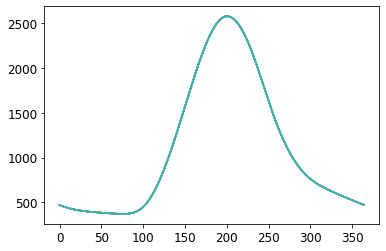

In [13]:
print(clim_dict['bute'].keys())

print(np.mean(clim_dict['bute']['Homathko']['interp_clim']))


#w = clim_dict['howe']['Fraser']['interp_clim'][:]
for i in range(0,10):
    plt.plot(wshed_tot[8,:])

In [14]:
cmap = cm.cm.phase  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#911eb4',\
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',\
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000',\
        '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000',
       'black','mediumseagreen','olivedrab','yellow','saddlebrown']

### watersheds of the model, showing only the top 5 rivers in each watershed

#### note that water is in model units: kg of water/m2 /s

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['SalmonSayward' 'Qunisam' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
bute
['Southgate' 'Homathko' 'Orford']
evi_s
['Cowichan1' 'Cowichan2' 'Goldstream' 'Puntledge' 'Chemanius2']


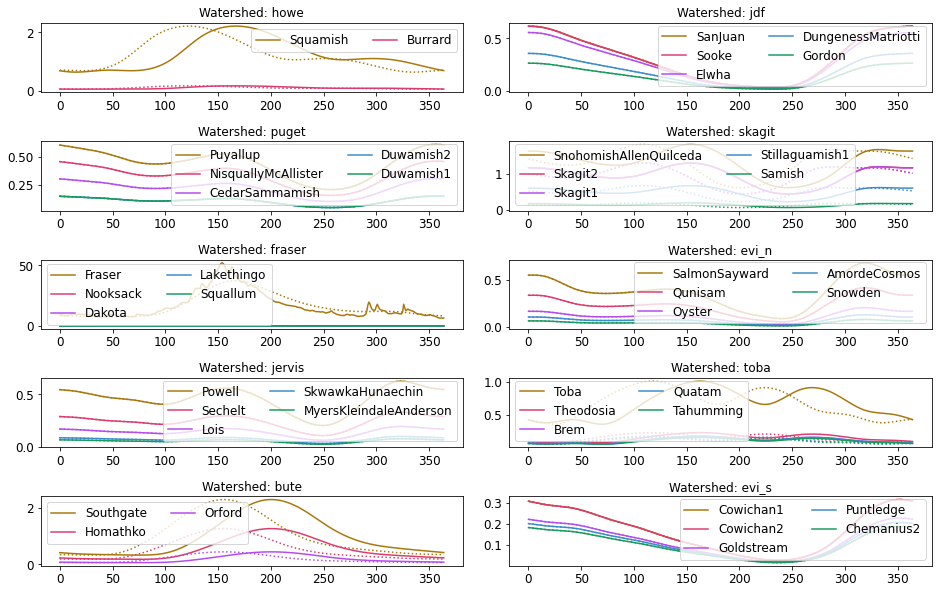

In [15]:
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    count = 0
    for riv in biggest_riv:
       
        #if riv in (biggest_riv):
        #print(count)
        #print(int(count/5 * 256))
        ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/5 * 256)])
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/5 * 256)])
        count = count+1

    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)

plt.tight_layout()

##### extraction functions for rivers (extract_ts_BASE and extract_ts_SHIFT) in _make_DICTS nb


In [16]:
start ='2017-01-01'; end ='2017-12-31'

start_run = arrow.get(start); end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

dayslen = len(arrow_array); atcco2_array = np.zeros(dayslen); dec_time_array = np.zeros(dayslen)


#constants from SKOG for BR run

LR_slope   =  2.149     #  linear regression + gaussian fit
LR_int     =  -3929.359 #  to seasonal cycle of atmospheric co2
ctr        =  161.898   #  based on scripps observations at ptbarrow and lajolla
amp        =  7.083     #  calc notebook by TJSJ
wid        =  44.703    #  notebook loc:
ctr2       =  218.832   #  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #
wid2       =  87.8836   #
ctr3       =  199.430   #
amp3       =  8.026     #
wid3       =  -185.920  #

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)



In [17]:
np.mean(clim_dict['bute']['Homathko']['interp_clim'])

318.99698

In [18]:
def make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed):
    
    riv_runoff = clim_dict[whsed][rivnam]['interp_clim']
    riv_runoff_SHIFT = riv_runoff
    wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    if whsed in wat_to_rot:
        riv_runoff_SHIFT = np.roll(riv_runoff,-45)
        
    if rivnam == 'Fraser':
        riv_runoff = hydroFraser_2017real
        riv_runoff_SHIFT = np.roll(hydroFraser_2017real,-45)

    riv_pkl = pickle.load(open(rivstr, 'rb'))  
    riv_pkl_SHIFT = pickle.load(open(rivstr_SHIFT, 'rb'))  
    #print(riv_runoff)
    
    radloc = 3
    radbroad = 10
    
    #print(riv_pkl)
    #co2flux_rad10
    sal_loc = riv_pkl['sal_rad3']
    sal_broad = riv_pkl['sal_rad10']
    sal_loc_SHIFT= riv_pkl_SHIFT['sal_rad3']
    sal_broad_SHIFT= riv_pkl_SHIFT['sal_rad10'] 
    temp_loc = riv_pkl['temp_rad3']
    temp_broad = riv_pkl['temp_rad10']
    temp_loc_SHIFT = riv_pkl_SHIFT['temp_rad3']
    temp_broad_SHIFT = riv_pkl_SHIFT['temp_rad10']    
    TA_loc = riv_pkl['TA_rad3']
    TA_broad = riv_pkl['TA_rad10']
    TA_loc_SHIFT = riv_pkl_SHIFT['TA_rad3']
    TA_broad_SHIFT = riv_pkl_SHIFT['TA_rad10']    
    DIC_loc = riv_pkl['DIC_rad3']
    DIC_broad = riv_pkl['DIC_rad10']            
    DIC_loc_SHIFT= riv_pkl_SHIFT['DIC_rad3']
    DIC_broad_SHIFT= riv_pkl_SHIFT['DIC_rad10']
    co2flux_loc = riv_pkl['co2flux_rad3']
    co2flux_broad = riv_pkl['co2flux_rad10']
    co2flux_loc_SHIFT= riv_pkl_SHIFT['co2flux_rad3']
    co2flux_broad_SHIFT= riv_pkl_SHIFT['co2flux_rad10'] 
    
    fs = 14
    fact = 0.65
    fig = plt.figure(figsize=(22*fact,18*fact))
    for i in range(1,7):
        ax = fig.add_subplot(3,2,i)

        
        #river cycle 
        if i == 1:
            ax.plot(np.arange(1,366,1),riv_runoff,'k-', label = 'BASE')
            ax.plot(np.arange(1,366,1),riv_runoff_SHIFT,'r-', label = 'SHIFT')
            ax.set_xlim([0,400])
            ax.set_title('Runoff by DOY, river: '+rivnam +'\n (time of interest highlighted)', fontsize = fs)
            ax.set_ylabel('m$^3$s$^{-1}$')
            ax.set_xlabel('day of year')
            ax.legend(loc = 'best')
            
            ## plotting errorbars
            plt.errorbar(405, np.mean(riv_runoff_SHIFT), np.std(riv_runoff_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            plt.errorbar(385, np.mean(riv_runoff), np.std(riv_runoff), \
                         linestyle='-', marker='.', color = 'k')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
        
#         #salinity
        if i == 3:
            ax.plot(np.arange(sd,ed+1,1),sal_loc,'k-', label = 'rad. = '+str(radloc) +' cells \n from rivmouth')
            ax.plot(np.arange(sd,ed+1,1),sal_broad,'k:', label = 'rad. = '+str(radbroad) +' cells')
            ax.plot(np.arange(sd,ed+1,1),sal_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),sal_broad_SHIFT,'r:' )

            ax.set_xlim([0,400])
            plt.legend(loc = 3)
            ax.set_ylabel('salinity g/kg')
            ax.set_xlabel('day of year')
            ax.set_title('Salinity', fontsize = fs)
            ####### plotting errorbars
            plt.errorbar(405, np.mean(sal_loc_SHIFT), np.std(sal_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(sal_broad_SHIFT), np.std(sal_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(sal_loc), np.std(sal_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(sal_broad), np.std(sal_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])

            #DIC
        
        if i == 5:

            ax.plot(np.arange(sd,ed+1,1),DIC_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),DIC_broad,'k:')
            ax.plot(np.arange(sd,ed+1,1),DIC_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),DIC_broad_SHIFT,'r:' )            
            ax.set_xlim([0,400])
            ax.set_ylabel('DIC  mmol m$^{-3}$')
            ax.set_xlabel('day of year')
            ax.set_title('DIC', fontsize = fs)
            plt.errorbar(405, np.mean(DIC_loc_SHIFT), np.std(DIC_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(DIC_broad_SHIFT), np.std(DIC_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(DIC_loc), np.std(DIC_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(DIC_broad), np.std(DIC_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
            #         plt.tight_layout()
#empty            
        if i == 7:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        
#### right column - pco2 - pco2 diseq
        if i == 2:
                    
            tsra = np.ravel(sal_loc)
            ttera = np.ravel(temp_loc)
            ttara = np.ravel(TA_loc) * 1e-3
            tdra = np.ravel(DIC_loc) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2_loc,fco2,co2,hco3,co3,OmegaA_loc,OmegaC,BetaD,DENis,p,Tis = response_tup

            tsra = np.ravel(sal_broad)
            ttera = np.ravel(temp_broad)
            ttara = np.ravel(TA_broad) * 1e-3
            tdra = np.ravel(DIC_broad) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2_broad,fco2,co2,hco3,co3,OmegaA_broad,OmegaC,BetaD,DENis,p,Tis = response_tup

            ax.plot(np.arange(sd,ed+1,1),pco2_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),pco2_broad,'k:')

            tsra = np.ravel(sal_loc_SHIFT)
            ttera = np.ravel(temp_loc_SHIFT)
            ttara = np.ravel(TA_loc_SHIFT) * 1e-3
            tdra = np.ravel(DIC_loc_SHIFT) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2_loc_SHIFT,fco2,co2,hco3,co3,OmegaA_loc_SHIFT,OmegaC,BetaD,DENis,p,Tis = response_tup

            tsra = np.ravel(sal_broad_SHIFT)
            ttera = np.ravel(temp_broad_SHIFT)
            ttara = np.ravel(TA_broad_SHIFT) * 1e-3
            tdra = np.ravel(DIC_broad_SHIFT) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2_broad_SHIFT,fco2,co2,hco3,co3,OmegaA_broad_SHIFT,OmegaC,BetaD,DENis,p,Tis = response_tup

            ax.plot(np.arange(sd,ed+1,1),pco2_loc_SHIFT,'r-')
            ax.plot(np.arange(sd,ed+1,1),pco2_broad_SHIFT,'r:')
            
            ax.plot(np.arange(0,365,1), atcco2_array, color = 'blue')
            ax.set_ylabel('pCO$_2$')
            ax.set_title('pCO$_2$', fontsize = fs)
            
            ####### plotting errorbars
            plt.errorbar(405, np.mean(pco2_loc_SHIFT), np.std(pco2_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(pco2_broad_SHIFT), np.std(pco2_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(pco2_loc), np.std(pco2_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(pco2_broad), np.std(pco2_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
        
        
#         #pco2 disequilibrium 
        if i == 4:
        
            ax.plot(np.arange(sd,ed+1,1),pco2_loc-atcco2_array,'k-')
            ax.plot(np.arange(sd,ed+1,1),pco2_broad-atcco2_array,'k:')
            ax.plot(np.arange(sd,ed+1,1),pco2_loc_SHIFT-atcco2_array,'r-')
            ax.plot(np.arange(sd,ed+1,1),pco2_broad_SHIFT-atcco2_array,'r:')
            
            #ax.plot(np.arange(0,365,1), atcco2_array, color = 'blue')
            ax.set_ylabel('pCO$_2$ disequilibrium ')
            ax.set_title('pCO$_2$ disequilibrium ', fontsize = fs)
            
            ####### plotting errorbars
            plt.errorbar(405, np.mean(pco2_loc_SHIFT-atcco2_array), np.std(pco2_loc_SHIFT-atcco2_array), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(pco2_broad_SHIFT-atcco2_array), np.std(pco2_loc_SHIFT-atcco2_array), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(pco2_loc-atcco2_array), np.std(pco2_loc-atcco2_array), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(pco2_broad-atcco2_array), np.std(pco2_loc-atcco2_array), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
                
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            plt.axhline(y=0, color = 'b')
            ax.set_xlim([0,415])
                
        if i == 6:

            ax.plot(np.arange(sd,ed+1,1),co2flux_loc,'k-', label = 'rad. = '+str(radloc) +' cells \n from rivmouth')
            ax.plot(np.arange(sd,ed+1,1),co2flux_broad,'k:', label = 'rad. = '+str(radbroad) +' cells')
            ax.plot(np.arange(sd,ed+1,1),co2flux_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),co2flux_broad_SHIFT,'r:' )

            ax.set_xlim([0,400])
            ax.set_ylabel('co2flux mmol/m2/s')
            ax.set_xlabel('day of year')
            ax.set_title('co2flux', fontsize = fs)
            ####### plotting errorbars
            plt.errorbar(405, np.mean(co2flux_loc_SHIFT), np.std(co2flux_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(co2flux_broad_SHIFT), np.std(co2flux_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(co2flux_loc), np.std(co2flux_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(co2flux_broad), np.std(co2flux_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
            plt.axhline(y=0, color = 'b')
        
        if i != 7:
            plt.axvline(x=365, color = 'k')
        
        if i == 8:
            ax.plot(np.arange(sd,ed+1,1),co2flux_loc,'k-', label = 'rad. = '+str(radloc) +' cells \n from rivmouth')
            ax.plot(np.arange(sd,ed+1,1),co2flux_broad,'k:', label = 'rad. = '+str(radbroad) +' cells')
            ax.plot(np.arange(sd,ed+1,1),co2flux_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),co2flux_broad_SHIFT,'r:' )

            ax.set_xlim([0,400])
            ax.set_ylabel('co2flux mmol/m2/s')
            ax.set_xlabel('day of year')
            ax.set_title('co2flux', fontsize = fs)
            ####### plotting errorbars
            plt.errorbar(405, np.mean(co2flux_loc_SHIFT), np.std(co2flux_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(co2flux_broad_SHIFT), np.std(co2flux_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(co2flux_loc), np.std(co2flux_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(co2flux_broad), np.std(co2flux_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
            plt.axhline(y=0, color = 'b')
        
        if i != 7:
            plt.axvline(x=365, color = 'k')
    
    
    plt.tight_layout()
    return




# Looking at the effects of a changed hydrograph on glacial river vicinity


# Fraser River

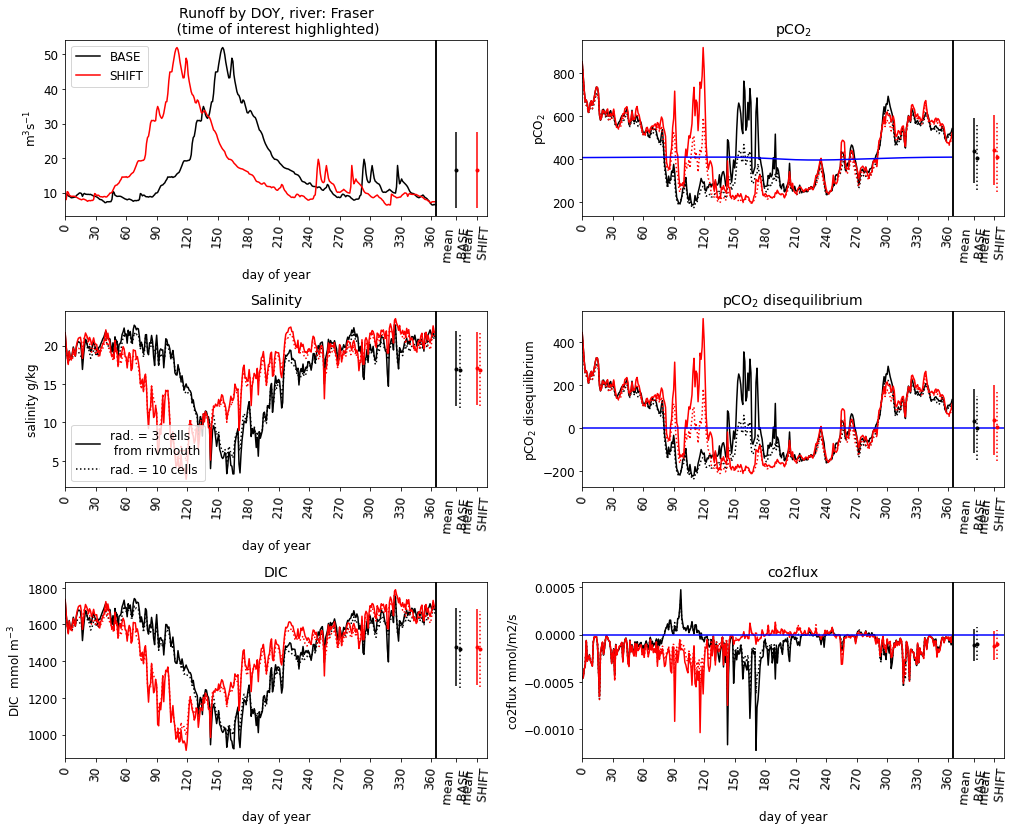

In [19]:
whsed = 'fraser'
rivnam = 'Fraser'
rivstr = './pkls/Fraser_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Fraser_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)



# Homathko

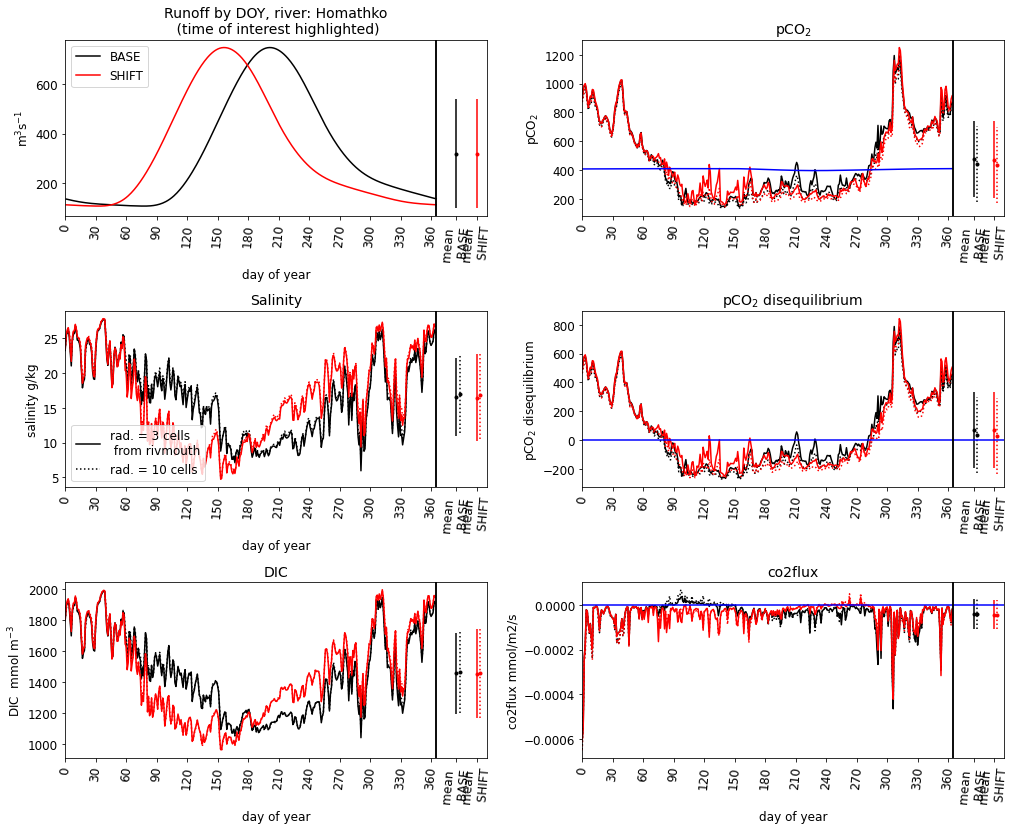

In [20]:
whsed = 'bute'
rivnam = 'Homathko'
rivstr = './pkls/Homathko_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Homathko_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)




# San Juan (not a glacial river)

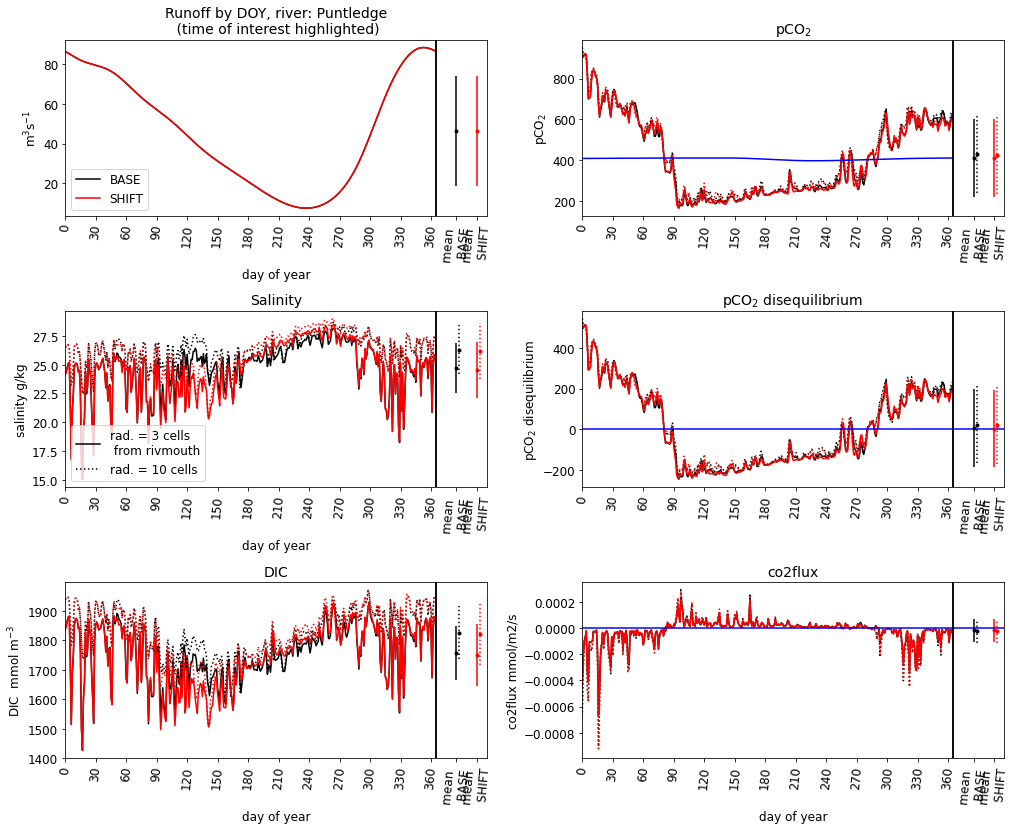

In [21]:
whsed = 'evi_s'
rivnam = 'Puntledge'
rivstr = './pkls/Puntledge_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Puntledge_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)



# Comparing surface salinity balances - domain-wide and nearshore


##### salinity extraction code 

In [22]:
GO = False

if GO == True:

    grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    lmask = grid['tmask'][0,0,:,:]
    print(np.shape(lmask))

    ## create .pkls of the actual as_flx
    start = '2017-01-01'
    end = '2017-12-31'
    vartyp = 'grid_T'

    BASE_sal = np.zeros([365,898,398])
    SHIFT_sal = np.zeros([365,898,398])

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        if i%30 == 0:
            print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['vosaline'][0,0,:,:]
        co2flx[lmask == 0] = np.nan
        BASE_sal[i,:,:] = co2flx   

        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['vosaline'][0,0,:,:] 
        co2flx[lmask == 0] = np.nan
        SHIFT_sal[i,:,:] = co2flx   


    pickle.dump(SHIFT_sal, open("./pkls/SHIFT_sal.pkl", 'wb'))
    pickle.dump(BASE_sal, open("./pkls/BASE_sal.pkl", 'wb'))


    grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    lmask = grid['tmask'][0,0,:,:]
    print(np.shape(lmask))

    ## create .pkls of the actual as_flx
    start = '2017-01-01'
    end = '2017-12-31'
    vartyp = 'grid_T'

    BASE_sal_NS = np.zeros([365,898,398])
    SHIFT_sal_NS = np.zeros([365,898,398])

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        if i%5 == 0:
            print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['vosaline'][0,0,:,:]
        co2flx[lmask == 0] = np.nan
        co2flx[co2flx > 20 ] = np.nan
        BASE_sal_NS[i,:,:] = co2flx   

        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['vosaline'][0,0,:,:] 
        co2flx[lmask == 0] = np.nan
        co2flx[co2flx > 20 ] = np.nan
        SHIFT_sal_NS[i,:,:] = co2flx   


    pickle.dump(SHIFT_sal_NS, open("./pkls/SHIFT_sal_NS.pkl", 'wb'))
    pickle.dump(BASE_sal_NS, open("./pkls/BASE_sal_NS.pkl", 'wb'))

##### salinity plotting code

BASE CASE MEAN: 25.748817050327418
SHIFT CASE MEAN: 25.67452600167188
DIFFERENCE, in percent: 0.2885221814669507


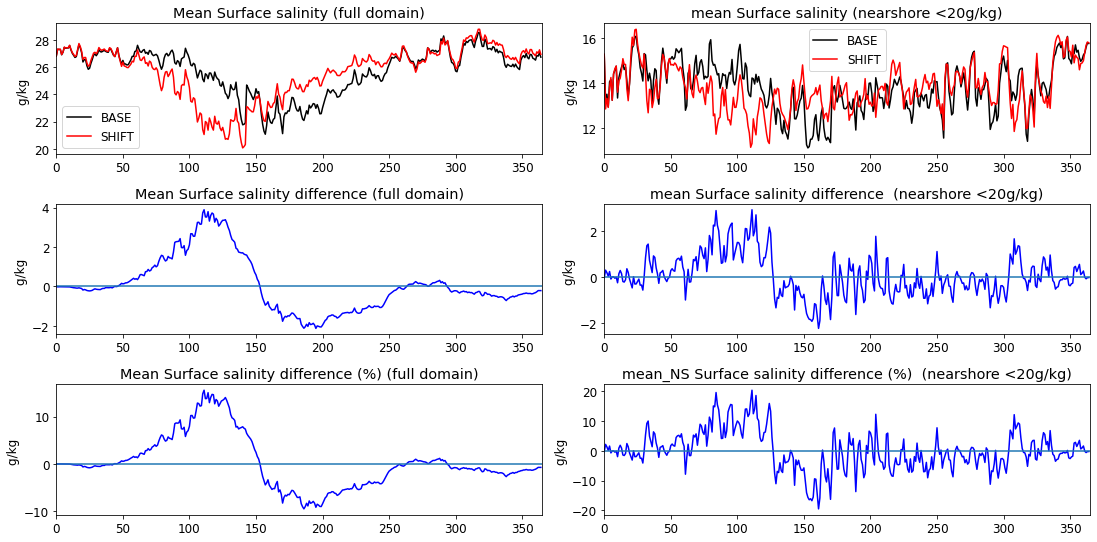

In [23]:
SHIFT_sal = pickle.load(open('./pkls/SHIFT_sal.pkl', 'rb'))  
BASE_sal = pickle.load(open('./pkls/BASE_sal.pkl', 'rb'))  
SHIFT_sal_NS = pickle.load(open('./pkls/SHIFT_sal_NS.pkl', 'rb'))  
BASE_sal_NS = pickle.load(open('./pkls/BASE_sal_NS.pkl', 'rb')) 

grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(grid)

SHIFT_mean = np.zeros(365)
BASE_mean = np.zeros(365)
SHIFT_mean_NS = np.zeros(365)
BASE_mean_NS = np.zeros(365)

for i in range(0,365):
    
    SHIFT_mean[i] = np.nanmean(SHIFT_sal[i,:,:])
    BASE_mean[i] = np.nanmean(BASE_sal[i,:,:])
    SHIFT_mean_NS[i] = np.nanmean(SHIFT_sal_NS[i,:,:])
    BASE_mean_NS[i] = np.nanmean(BASE_sal_NS[i,:,:])
    
fact = 1.1
fig = plt.figure(figsize=(14*fact,7*fact))

ax = fig.add_subplot(3,2,1)
ax.plot(BASE_mean,'k-', label = 'BASE')
ax.plot(SHIFT_mean,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); ax.set_ylabel('g/kg ')
ax.set_title('Mean Surface salinity (full domain)')

ax = fig.add_subplot(3,2,3)
ax.plot(BASE_mean-SHIFT_mean,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('g/kg ')
ax.set_title('Mean Surface salinity difference (full domain)')

ax = fig.add_subplot(3,2,5)
ax.plot(((BASE_mean-SHIFT_mean)/BASE_mean)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('g/kg ')
ax.set_title('Mean Surface salinity difference (%) (full domain)')

ax = fig.add_subplot(3,2,2)
ax.plot(BASE_mean_NS,'k-', label = 'BASE')
ax.plot(SHIFT_mean_NS,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); ax.set_ylabel('g/kg ')
ax.set_title('mean Surface salinity (nearshore <20g/kg)')

ax = fig.add_subplot(3,2,4)
ax.plot(BASE_mean_NS-SHIFT_mean_NS,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('g/kg ')
ax.set_title('mean Surface salinity difference  (nearshore <20g/kg)')

ax = fig.add_subplot(3,2,6)
ax.plot(((BASE_mean_NS-SHIFT_mean_NS)/BASE_mean_NS)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('g/kg ')
ax.set_title('mean_NS Surface salinity difference (%)  (nearshore <20g/kg)')
plt.tight_layout()

print('BASE CASE MEAN: ' + str(np.mean(BASE_mean)))
print('SHIFT CASE MEAN: ' + str(np.mean(SHIFT_mean)))
print('DIFFERENCE, in percent: ' + str((np.mean(BASE_mean)-np.mean(SHIFT_mean))/np.mean(BASE_mean)*100))

# Comparing surface omega_A balances

##### SURFACE OMEGA EXTRACTION code

In [24]:
GO = False

if GO == True:
    ############ DOMAIN-WIDE SURFACE OMA #################


    grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    lmask = grid['tmask'][0,0,:,:]
    print(np.shape(lmask))

    ## create .pkls of the actual as_flx
    start = '2017-01-01'
    end = '2017-12-31'

    BASE_oma = np.zeros([365,898,398])
    SHIFT_oma = np.zeros([365,898,398])

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        if i%30 == 0:
            print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '//data/tjarniko/results/RIV_PIL/Oma_calc/'
        guess = 'BASE_OmA_plus_'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['model_output']['OmA'][0,:,:] 
        co2flx[lmask == 0] = np.nan
        BASE_oma[i,:,:] = co2flx   

        guess = 'SHIFT_OmA_plus_'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['model_output']['OmA'][0,:,:] 
        co2flx[lmask == 0] = np.nan
        SHIFT_oma[i,:,:] = co2flx   


    pickle.dump(SHIFT_oma, open("./pkls/SHIFT_oma.pkl", 'wb'))
    pickle.dump(BASE_oma, open("./pkls/BASE_oma.pkl", 'wb'))

    ############ NEARSHORE SURFACE OMA #################

    SHIFT_sal = pickle.load(open('./pkls/SHIFT_sal.pkl', 'rb'))  
    BASE_sal = pickle.load(open('./pkls/BASE_sal.pkl', 'rb'))  

    grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    lmask = grid['tmask'][0,0,:,:]
    print(np.shape(lmask))

    ## create .pkls of the actual as_flx
    start = '2017-01-01'
    end = '2017-12-31'

    BASE_oma_NS= np.zeros([365,898,398])
    SHIFT_oma_NS = np.zeros([365,898,398])

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        if i%30 == 0:
            print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '//data/tjarniko/results/RIV_PIL/Oma_calc/'
        guess = 'BASE_OmA_plus_'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['model_output']['OmA'][0,:,:]
        ns_sal = BASE_sal[i,:,:]
        co2flx[ns_sal>20] = np.nan
        co2flx[lmask == 0] = np.nan
        BASE_oma_NS[i,:,:] = co2flx   

        guess = 'SHIFT_OmA_plus_'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['model_output']['OmA'][0,:,:] 
        ns_sal = SHIFT_sal[i,:,:]
        co2flx[ns_sal>20] = np.nan
        co2flx[lmask == 0] = np.nan
        SHIFT_oma_NS[i,:,:] = co2flx   


    pickle.dump(SHIFT_oma_NS, open("./pkls/SHIFT_oma_NS.pkl", 'wb'))
    pickle.dump(BASE_oma_NS, open("./pkls/BASE_oma_NS.pkl", 'wb'))

##### SURFACE OM_A PLOTTING CODE

BASE CASE MEAN: 1.4318591795998317
SHIFT CASE MEAN: 1.436795362673529
DIFFERENCE, in percent: -0.34473942298410254


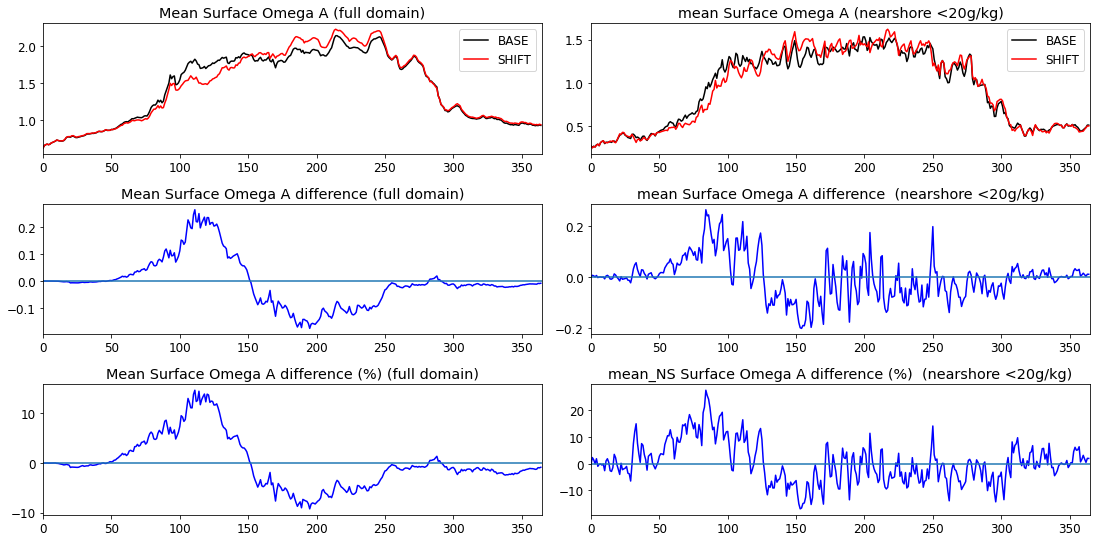

In [25]:
SHIFT_oma = pickle.load(open('./pkls/SHIFT_oma.pkl', 'rb'))  
BASE_oma = pickle.load(open('./pkls/BASE_oma.pkl', 'rb'))  
SHIFT_oma_NS = pickle.load(open('./pkls/SHIFT_oma_NS.pkl', 'rb'))  
BASE_oma_NS = pickle.load(open('./pkls/BASE_oma_NS.pkl', 'rb')) 

grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(grid)

SHIFT_mean = np.zeros(365)
BASE_mean = np.zeros(365)
SHIFT_mean_NS = np.zeros(365)
BASE_mean_NS = np.zeros(365)

for i in range(0,365):
    
    SHIFT_mean[i] = np.nanmean(SHIFT_oma[i,:,:])
    BASE_mean[i] = np.nanmean(BASE_oma[i,:,:])
    SHIFT_mean_NS[i] = np.nanmean(SHIFT_oma_NS[i,:,:])
    BASE_mean_NS[i] = np.nanmean(BASE_oma_NS[i,:,:])
    
fact = 1.1
fig = plt.figure(figsize=(14*fact,7*fact))

ax = fig.add_subplot(3,2,1)
ax.plot(BASE_mean,'k-', label = 'BASE')
ax.plot(SHIFT_mean,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); 
ax.set_title('Mean Surface Omega A (full domain)')

ax = fig.add_subplot(3,2,3)
ax.plot(BASE_mean-SHIFT_mean,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); 
ax.set_title('Mean Surface Omega A difference (full domain)')

ax = fig.add_subplot(3,2,5)
ax.plot(((BASE_mean-SHIFT_mean)/BASE_mean)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); 
ax.set_title('Mean Surface Omega A difference (%) (full domain)')

ax = fig.add_subplot(3,2,2)
ax.plot(BASE_mean_NS,'k-', label = 'BASE')
ax.plot(SHIFT_mean_NS,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); 
ax.set_title('mean Surface Omega A (nearshore <20g/kg)')

ax = fig.add_subplot(3,2,4)
ax.plot(BASE_mean_NS-SHIFT_mean_NS,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); 
ax.set_title('mean Surface Omega A difference  (nearshore <20g/kg)')

ax = fig.add_subplot(3,2,6)
ax.plot(((BASE_mean_NS-SHIFT_mean_NS)/BASE_mean_NS)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); 
ax.set_title('mean_NS Surface Omega A difference (%)  (nearshore <20g/kg)')
plt.tight_layout()

print('BASE CASE MEAN: ' + str(np.mean(BASE_mean)))
print('SHIFT CASE MEAN: ' + str(np.mean(SHIFT_mean)))
print('DIFFERENCE, in percent: ' + str((np.mean(BASE_mean)-np.mean(SHIFT_mean))/np.mean(BASE_mean)*100))

# Comparing air-sea flux balances

##### code to extract and pickle  daily air-sea flux into 1 large 365x898x398 array - land cells as NAN

In [26]:
GO = False

if GO == True:
    grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    lmask = grid['tmask'][0,0,:,:]
    print(np.shape(lmask))

    ## create .pkls of the actual as_flx
    start = '2017-01-01'
    end = '2017-12-31'
    vartyp = 'carp'

    BASE_flx = np.zeros([365,898,398])
    SHIFT_flx = np.zeros([365,898,398])

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        if i%30 == 0:
            print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['co2_flux_mmol_m2_s'][0,:,:] 
        co2flx[lmask == 0] = np.nan
        BASE_flx[i,:,:] = co2flx   

        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['co2_flux_mmol_m2_s'][0,:,:] 
        co2flx[lmask == 0] = np.nan
        SHIFT_flx[i,:,:] = co2flx   


    pickle.dump(SHIFT_flx, open("./pkls/SHIFT_flx.pkl", 'wb'))
    pickle.dump(BASE_flx, open("./pkls/BASE_flx.pkl", 'wb'))

    ####################### near-shore flux

    grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    lmask = grid['tmask'][0,0,:,:]
    print(np.shape(lmask))

    ## create .pkls of the actual as_flx
    start = '2017-01-01'
    end = '2017-12-31'
    vartyp = 'carp'

    BASE_flx_NS = np.zeros([365,898,398])
    SHIFT_flx_NS = np.zeros([365,898,398])

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        if i%30 == 0:
            print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['co2_flux_mmol_m2_s'][0,:,:] 
        ns_sal = BASE_sal[i,:,:]
        co2flx[ns_sal>20] = np.nan
        co2flx[lmask == 0] = np.nan
        BASE_flx_NS[i,:,:] = co2flx   

        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        co2flx = w['co2_flux_mmol_m2_s'][0,:,:] 
        ns_sal = SHIFT_sal[i,:,:]
        co2flx[ns_sal>20] = np.nan
        co2flx[lmask == 0] = np.nan
        SHIFT_flx_NS[i,:,:] = co2flx   


    pickle.dump(SHIFT_flx_NS, open("./pkls/SHIFT_flx_NS.pkl", 'wb'))
    pickle.dump(BASE_flx_NS, open("./pkls/BASE_flx_NS.pkl", 'wb'))

# CO2 flux difference plotting code

In [27]:
# np.nanmin(SHIFT_flx_NS)

BASE CASE MEAN: -6.451450117287233e-05
SHIFT CASE MEAN: -6.293809466387151e-05
DIFFERENCE, in percent: 2.4434917426962612


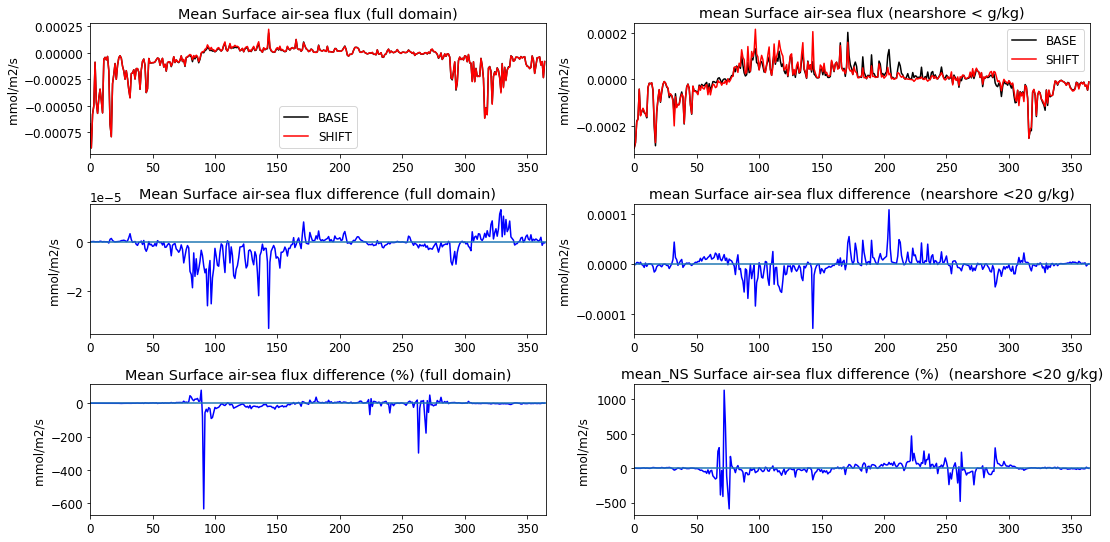

In [28]:
SHIFT_flx = pickle.load(open('./pkls/SHIFT_flx.pkl', 'rb'))  
BASE_flx = pickle.load(open('./pkls/BASE_flx.pkl', 'rb'))  
SHIFT_flx_NS = pickle.load(open('./pkls/SHIFT_flx_NS.pkl', 'rb'))  
BASE_flx_NS = pickle.load(open('./pkls/BASE_flx_NS.pkl', 'rb')) 

grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(grid)

SHIFT_mean = np.zeros(365)
BASE_mean = np.zeros(365)
SHIFT_mean_NS = np.zeros(365)
BASE_mean_NS = np.zeros(365)

for i in range(0,365):
    
    SHIFT_mean[i] = np.nanmean(SHIFT_flx[i,:,:])
    BASE_mean[i] = np.nanmean(BASE_flx[i,:,:])
    SHIFT_mean_NS[i] = np.nanmean(SHIFT_flx_NS[i,:,:])
    BASE_mean_NS[i] = np.nanmean(BASE_flx_NS[i,:,:])
    
fact = 1.1
fig = plt.figure(figsize=(14*fact,7*fact))

ax = fig.add_subplot(3,2,1)
ax.plot(BASE_mean,'k-', label = 'BASE')
ax.plot(SHIFT_mean,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('Mean Surface air-sea flux (full domain)')

ax = fig.add_subplot(3,2,3)
ax.plot(BASE_mean-SHIFT_mean,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('Mean Surface air-sea flux difference (full domain)')

ax = fig.add_subplot(3,2,5)
ax.plot(((BASE_mean-SHIFT_mean)/BASE_mean)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('Mean Surface air-sea flux difference (%) (full domain)')

ax = fig.add_subplot(3,2,2)
ax.plot(BASE_mean_NS,'k-', label = 'BASE')
ax.plot(SHIFT_mean_NS,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('mean Surface air-sea flux (nearshore < g/kg)')

ax = fig.add_subplot(3,2,4)
ax.plot(BASE_mean_NS-SHIFT_mean_NS,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('mean Surface air-sea flux difference  (nearshore <20 g/kg)')

ax = fig.add_subplot(3,2,6)
ax.plot(((BASE_mean_NS-SHIFT_mean_NS)/BASE_mean_NS)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('mean_NS Surface air-sea flux difference (%)  (nearshore <20 g/kg)')
plt.tight_layout()

print('BASE CASE MEAN: ' + str(np.mean(BASE_mean)))
print('SHIFT CASE MEAN: ' + str(np.mean(SHIFT_mean)))
print('DIFFERENCE, in percent: ' + str((np.mean(BASE_mean)-np.mean(SHIFT_mean))/np.mean(BASE_mean)*100))

In [29]:
# SHIFT_flx = pickle.load(open('./pkls/SHIFT_flx.pkl', 'rb'))  
# BASE_flx = pickle.load(open('./pkls/BASE_flx.pkl', 'rb'))  

# grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# #print(grid)

# SHIFT_mean = np.zeros(365)
# BASE_mean = np.zeros(365)

# for i in range(0,365):
    
#     SHIFT_mean[i] = np.nanmean(SHIFT_flx[i,:,:])
#     BASE_mean[i] = np.nanmean(BASE_flx[i,:,:])


# fact = 1
# fig = plt.figure(figsize=(10*fact,5*fact))

# ax = fig.add_subplot(2,1,1)
# ax.plot(BASE_mean,'k-', label = 'BASE')
# ax.plot(SHIFT_mean,'r-', label = 'SHIFT')
# ax.axhline(y=0)
# ax.legend()
# ax.set_xlim([0,365])
# ax.set_ylabel('AS flux mmol/m2/s \n negative = out')
# ax.set_title('mean daily air-sea flux')

# ax = fig.add_subplot(2,1,2)
# ax.plot(BASE_mean-SHIFT_mean,'k-')
# ax.axhline(y=0)
# ax.set_xlim([0,365])
# ax.set_title('mean daily air-sea flux difference - BASE-SHIFT')
# ax.set_ylabel('AS flux mmol/m2/s \n negative = out')
# plt.tight_layout()

# print('BASE CASE MEAN (MMOL/M2/DAY): ' + str(np.mean(BASE_mean)))
# print('SHIFT CASE MEAN (MMOL/M2/DAY): ' + str(np.mean(SHIFT_mean)))
# print('DIFFERENCE, in percent: ' + str((np.mean(BASE_mean)-np.mean(SHIFT_mean))/np.mean(BASE_mean)*100))

### Monthly spatial means of air-sea flux, including pickling code

In [30]:
GO = False

if GO == True:

    days_mon = [31,28,31,30,31,30,31,31,30,31,30,31]

    days_starts = np.zeros(12)
    days_ends = np.zeros(12)

    for i in range(0,12):
        days_ends[i] = np.sum(days_mon[0:i+1])

    days_starts = days_ends - days_mon
    print(days_starts)
    print(days_ends)

    days_starts = days_starts.astype(int)
    days_ends = days_ends.astype(int)

    SHIFT_flx_mon = np.zeros([12,898,398])
    BASE_flx_mon = np.zeros([12,898,398])

    for i in range(0,12):
        SHIFT_flx_mon[i,:,:] = np.nanmean(SHIFT_flx[days_starts[i]:days_ends[i],:,:],axis = 0)
        BASE_flx_mon[i,:,:] = np.nanmean(BASE_flx[days_starts[i]:days_ends[i],:,:],axis = 0)

    pickle.dump(SHIFT_flx_mon, open("./pkls/SHIFT_flx_mon.pkl", 'wb'))
    pickle.dump(BASE_flx_mon, open("./pkls/BASE_flx_mon.pkl", 'wb'))

jan, SHIFT OUTGASSING MORE, mean difference mmol/m2/s
2.514773657338346e-07
feb, BASE OUTGASSING MORE mean difference mmol/m2/s
-5.278824600032731e-07
mar, BASE OUTGASSING MORE mean difference mmol/m2/s
-5.143755941213238e-06
apr, BASE OUTGASSING MORE mean difference mmol/m2/s
-8.708950210005118e-06
may, BASE OUTGASSING MORE mean difference mmol/m2/s
-6.389719789894654e-06
jun, BASE OUTGASSING MORE mean difference mmol/m2/s
-1.0536170142223447e-06
jul, SHIFT OUTGASSING MORE, mean difference mmol/m2/s
1.1391949613900693e-06
aug, BASE OUTGASSING MORE mean difference mmol/m2/s
-3.5468338457847765e-07
sep, BASE OUTGASSING MORE mean difference mmol/m2/s
-6.400690240793465e-07
oct, BASE OUTGASSING MORE mean difference mmol/m2/s
-2.3178473888950818e-06
nov, SHIFT OUTGASSING MORE, mean difference mmol/m2/s
3.686521810729036e-06
dec, SHIFT OUTGASSING MORE, mean difference mmol/m2/s
1.230681474945317e-06


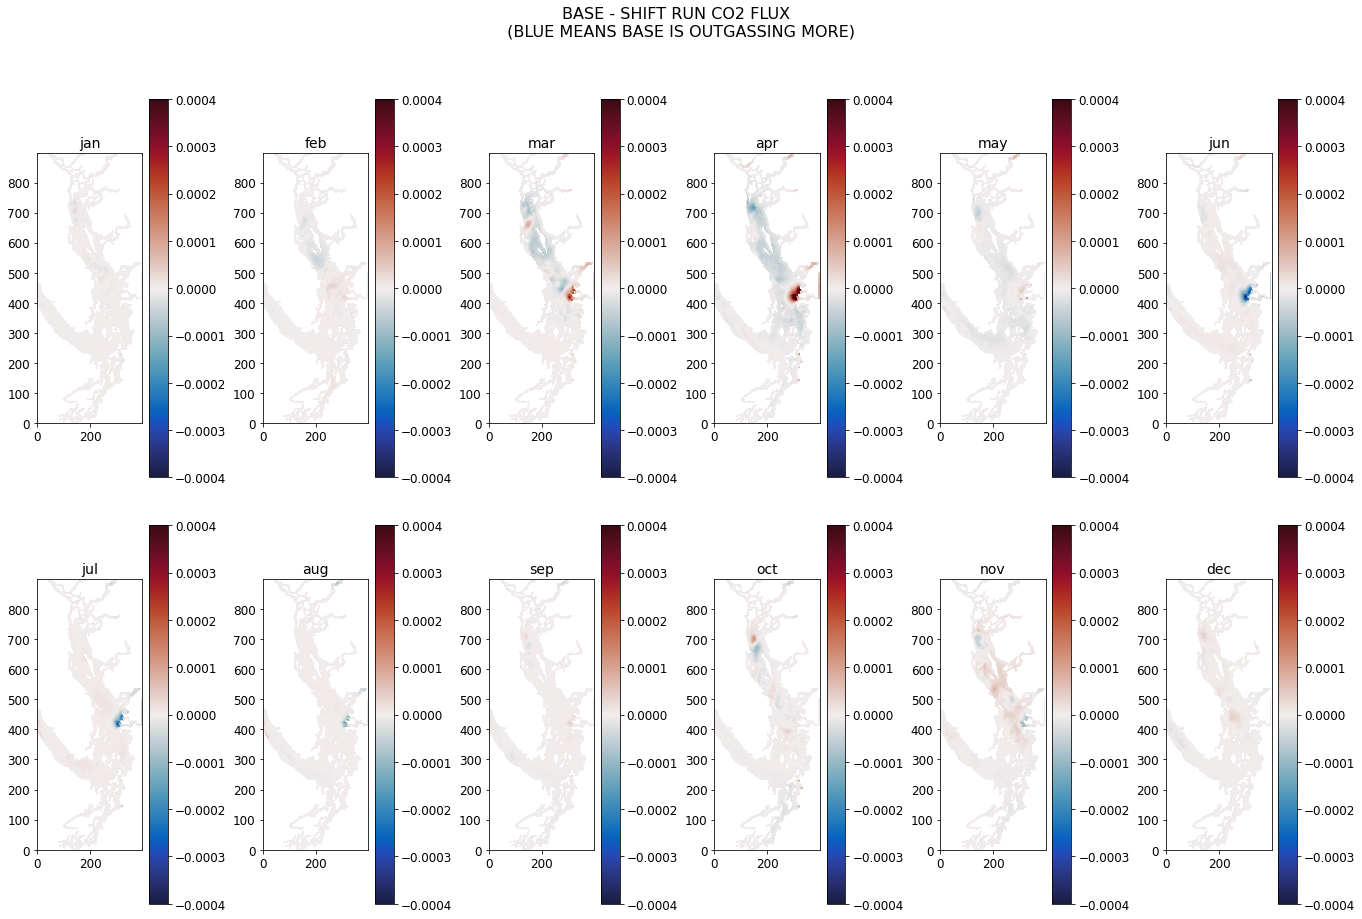

In [31]:
SHIFT_flx_mon = pickle.load(open('./pkls/SHIFT_flx_mon.pkl', 'rb'))  
BASE_flx_mon = pickle.load(open('./pkls/BASE_flx_mon.pkl', 'rb'))  
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

fact = 1.9
fig = plt.figure(figsize=(10*fact,6.66*fact))
for i in range(1,13):
    ax = fig.add_subplot(2,6,i)
    viz_tools.set_aspect(ax)
    tdiff = BASE_flx_mon[i-1,:,:]-SHIFT_flx_mon[i-1,:,:]
    meandiff = (np.nanmean(tdiff))
    t = 'Outgass dominance not defined'
    if meandiff < 0 :
        t = ', BASE OUTGASSING MORE mean difference mmol/m2/s'
    if meandiff > 0 :
        t = ', SHIFT OUTGASSING MORE, mean difference mmol/m2/s'
    print(months[i-1] + t)
    print(meandiff)
    
    
    mesh = ax.pcolormesh(tdiff, cmap=cm.cm.balance, vmin = -0.0004, vmax = 0.0004)
    
    ax.set_title(months[i-1], fontsize = 14)
    fig.colorbar(mesh)

plt.suptitle('BASE - SHIFT RUN CO2 FLUX \n (BLUE MEANS BASE IS OUTGASSING MORE)', fontsize = 16, y = 1.02)
    
plt.tight_layout()

## SHIFT COLOURMAP TO VISUALIZE DIFFERENCES MORE CLEARLY

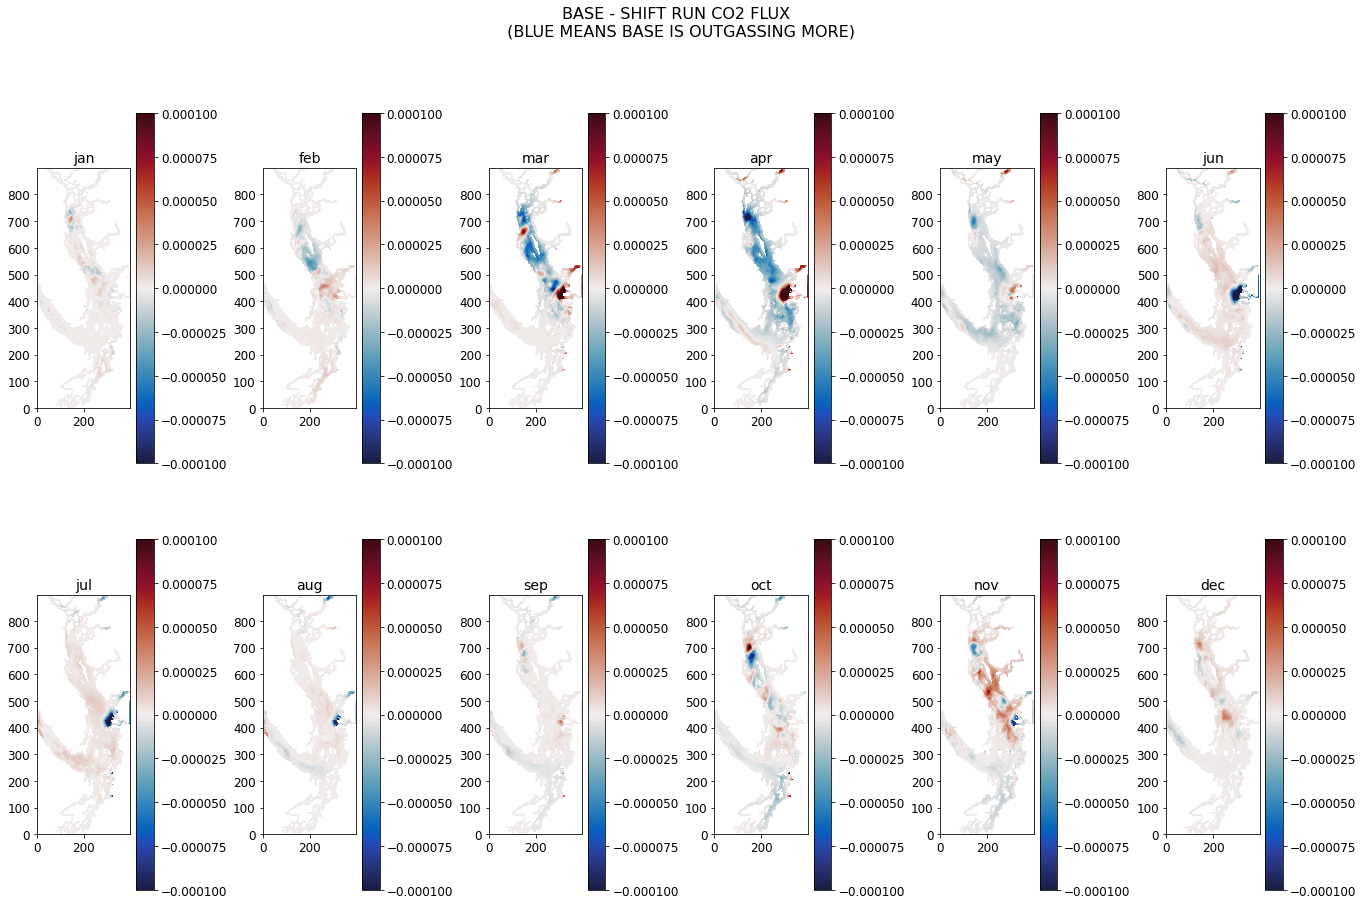

In [32]:
SHIFT_flx_mon = pickle.load(open('./pkls/SHIFT_flx_mon.pkl', 'rb'))  
BASE_flx_mon = pickle.load(open('./pkls/BASE_flx_mon.pkl', 'rb'))  
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

fact = 1.9
fig = plt.figure(figsize=(10*fact,6.66*fact))
for i in range(1,13):
    ax = fig.add_subplot(2,6,i)
    viz_tools.set_aspect(ax)
    tdiff = BASE_flx_mon[i-1,:,:]-SHIFT_flx_mon[i-1,:,:]
    mesh = ax.pcolormesh(tdiff, cmap=cm.cm.balance, vmin = -0.0001, vmax = 0.0001)
    
    ax.set_title(months[i-1], fontsize = 14)
    fig.colorbar(mesh)

plt.suptitle('BASE - SHIFT RUN CO2 FLUX \n (BLUE MEANS BASE IS OUTGASSING MORE)', fontsize = 16, y = 1.02)
    
plt.tight_layout()

# Comparing productivity - diatoms+flag+cill, top 20 m. 

In [33]:
GO = True

if GO == True:
#     grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#     lmask = grid['tmask'][0,0,:,:]
#     print(np.shape(lmask))

#     ## create .pkls of the actual as_prod
#     start = '2017-01-01'
#     end = '2017-12-31'
#     vartyp = 'ptrc'
#     start_run = arrow.get(start)
#     end_run = arrow.get(end)

#     arrow_array = []

#     for r in arrow.Arrow.span_range('day', start_run, end_run):
#         arrow_array.append(r)
        
#     BASE_prod = np.zeros([365,898,398])
#     SHIFT_prod = np.zeros([365,898,398])

#     dayslen = len(arrow_array)
#     #print(dayslen)
#     ts = np.zeros(dayslen)
#     #print(arrow_array)
#     for i in range(0,dayslen):
        
#         print(i)
#         tdate = arrow_array[i][0]
#         ymd = tdate.format('YYYYMMDD')
#         tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
#         guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
#         w = glob.glob(tdir+guess)
#         w = nc.Dataset(w[0])
#         diat = w['diatoms'][0,0:20,:,:] 
#         cil = w['ciliates'][0,0:20,:,:] 
#         flag = w['flagellates'][0,0:20,:,:]    
#         tprod = (diat+cil+flag)
#         #print(np.shape(tprod))
#         BASE_prod[i,:,:] = (np.nanmean(tprod,axis = 0))

#         tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
#         guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
#         w = glob.glob(tdir+guess)
#         w = nc.Dataset(w[0])
#         diat = w['diatoms'][0,0:20,:,:] 
#         cil = w['ciliates'][0,0:20,:,:] 
#         flag = w['flagellates'][0,0:20,:,:] 
#         tprod = (diat+cil+flag)
#         SHIFT_prod[i,:,:] = (np.nanmean(tprod,axis = 0))


#     pickle.dump(SHIFT_prod, open("./pkls/SHIFT_prod.pkl", 'wb'))
#     pickle.dump(BASE_prod, open("./pkls/BASE_prod.pkl", 'wb'))
# ##### nearshore productivity

    BASE_prod_NS = np.zeros([365,898,398])
    SHIFT_prod_NS = np.zeros([365,898,398])

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):
        
        print(i)
        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        diat = w['diatoms'][0,0:20,:,:] 
        cil = w['ciliates'][0,0:20,:,:] 
        flag = w['flagellates'][0,0:20,:,:]    
        tprod = (diat+cil+flag)
        ns_sal = BASE_sal[i,:,:]
        tprod = (np.nanmean(tprod,axis = 0))
        tprod[ns_sal>20] = np.nan
        #print(np.shape(tprod))
        
        BASE_prod_NS[i,:,:] = tprod

        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = nc.Dataset(w[0])
        diat = w['diatoms'][0,0:20,:,:] 
        cil = w['ciliates'][0,0:20,:,:] 
        flag = w['flagellates'][0,0:20,:,:] 
        tprod = (diat+cil+flag)
        ns_sal = SHIFT_sal[i,:,:]
        tprod = (np.nanmean(tprod,axis = 0))
        tprod[ns_sal>20] = np.nan
        #print(np.shape(tprod))
        SHIFT_prod_NS[i,:,:] = tprod
        
    pickle.dump(SHIFT_prod_NS, open("./pkls/SHIFT_prod_NS.pkl", 'wb'))
    pickle.dump(BASE_prod_NS, open("./pkls/BASE_prod_NS.pkl", 'wb'))

0


NameError: name 'vartyp' is not defined

In [ ]:
SHIFT_prod = pickle.load(open('./pkls/SHIFT_prod.pkl', 'rb'))  
BASE_prod = pickle.load(open('./pkls/BASE_prod.pkl', 'rb'))  
SHIFT_prod_NS = pickle.load(open('./pkls/SHIFT_prod_NS.pkl', 'rb'))  
BASE_prod_NS = pickle.load(open('./pkls/BASE_prod_NS.pkl', 'rb')) 

grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(grid)

SHIFT_mean = np.zeros(365)
BASE_mean = np.zeros(365)
SHIFT_mean_NS = np.zeros(365)
BASE_mean_NS = np.zeros(365)

for i in range(0,365):
    
    SHIFT_mean[i] = np.nanmean(SHIFT_prod[i,:,:])
    BASE_mean[i] = np.nanmean(BASE_prod[i,:,:])
    SHIFT_mean_NS[i] = np.nanmean(SHIFT_prod_NS[i,:,:])
    BASE_mean_NS[i] = np.nanmean(BASE_prod_NS[i,:,:])
    
fact = 1.1
fig = plt.figure(figsize=(14*fact,7*fact))

ax = fig.add_subplot(3,2,1)
ax.plot(BASE_mean,'k-', label = 'BASE')
ax.plot(SHIFT_mean,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('Mean Surface air-sea flux (full domain)')

ax = fig.add_subplot(3,2,3)
ax.plot(BASE_mean-SHIFT_mean,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('Mean Surface air-sea flux difference (full domain)')

ax = fig.add_subplot(3,2,5)
ax.plot(((BASE_mean-SHIFT_mean)/BASE_mean)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('Mean Surface air-sea flux difference (%) (full domain)')

ax = fig.add_subplot(3,2,2)
ax.plot(BASE_mean_NS,'k-', label = 'BASE')
ax.plot(SHIFT_mean_NS,'r-', label = 'SHIFT')
ax.legend(); ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('mean Surface air-sea flux (nearshore <20mmol/m2/s)')

ax = fig.add_subplot(3,2,4)
ax.plot(BASE_mean_NS-SHIFT_mean_NS,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('mean Surface air-sea flux difference  (nearshore <20mmol/m2/s)')

ax = fig.add_subplot(3,2,6)
ax.plot(((BASE_mean_NS-SHIFT_mean_NS)/BASE_mean_NS)*100,'b-', label = 'BASE')
ax.axhline(y=0)
ax.set_xlim([0,365]); ax.set_ylabel('mmol/m2/s ')
ax.set_title('mean_NS Surface air-sea flux difference (%)  (nearshore <20mmol/m2/s)')
plt.tight_layout()

print('BASE CASE MEAN: ' + str(np.mean(BASE_mean)))
print('SHIFT CASE MEAN: ' + str(np.mean(SHIFT_mean)))
print('DIFFERENCE, in percent: ' + str((np.mean(BASE_mean)-np.mean(SHIFT_mean))/np.mean(BASE_mean)*100))

In [ ]:
# SHIFT_prod = pickle.load(open('./pkls/SHIFT_prod.pkl', 'rb'))  
# BASE_prod = pickle.load(open('./pkls/BASE_prod.pkl', 'rb'))  

# grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# #print(grid)

# SHIFT_mean = np.zeros(365)
# BASE_mean = np.zeros(365)

# for i in range(0,365):
    
#     SHIFT_mean[i] = np.nanmean(SHIFT_prod[i,:,:])
#     BASE_mean[i] = np.nanmean(BASE_prod[i,:,:])


# fact = 1
# fig = plt.figure(figsize=(10*fact,5*fact))

# ax = fig.add_subplot(2,1,1)
# ax.plot(BASE_mean,'k-', label = 'BASE')
# ax.plot(SHIFT_mean,'r-', label = 'SHIFT')
# ax.axhline(y=0)
# ax.legend()
# ax.set_xlim([0,365])
# ax.set_ylabel('mean top 20m primary productivity \n (mmol N/m3)')
# ax.set_title('Mean top 20m primary productivity')

# ax = fig.add_subplot(2,1,2)
# ax.plot(BASE_mean-SHIFT_mean,'k-')
# ax.axhline(y=0)
# ax.set_xlim([0,365])
# ax.set_title('Mean top 20m primary productivity difference - BASE-SHIFT')
# ax.set_ylabel('mean top 20m primary productivity \n (mmol N/m3)')
# plt.tight_layout()

# print('BASE CASE MEAN (MMOL/M3 20m mean): ' + str(np.mean(BASE_mean)))
# print('SHIFT CASE MEAN (MMOL/M3 20m mean): ' + str(np.mean(SHIFT_mean)))
# print('DIFFERENCE, in percent: ' + str((np.mean(BASE_mean)-np.mean(SHIFT_mean))/np.mean(BASE_mean)*100))

In [ ]:
#monthly spatial means
days_mon = [31,28,31,30,31,30,31,31,30,31,30,31]

days_starts = np.zeros(12)
days_ends = np.zeros(12)

for i in range(0,12):
    days_ends[i] = np.sum(days_mon[0:i+1])

days_starts = days_ends - days_mon
print(days_starts)
print(days_ends)

days_starts = days_starts.astype(int)
days_ends = days_ends.astype(int)

SHIFT_prod_mon = np.zeros([12,898,398])
BASE_prod_mon = np.zeros([12,898,398])

for i in range(0,12):
    SHIFT_prod_mon[i,:,:] = np.nanmean(SHIFT_prod[days_starts[i]:days_ends[i],:,:],axis = 0)
    BASE_prod_mon[i,:,:] = np.nanmean(BASE_prod[days_starts[i]:days_ends[i],:,:],axis = 0)
    
pickle.dump(SHIFT_prod_mon, open("./pkls/SHIFT_prod_mon.pkl", 'wb'))
pickle.dump(BASE_prod_mon, open("./pkls/BASE_prod_mon.pkl", 'wb'))

In [ ]:
SHIFT_prod_mon = pickle.load(open('./pkls/SHIFT_prod_mon.pkl', 'rb'))  
BASE_prod_mon = pickle.load(open('./pkls/BASE_prod_mon.pkl', 'rb'))  
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

fact = 1.9
fig = plt.figure(figsize=(10*fact,6.66*fact))
for i in range(1,13):
    ax = fig.add_subplot(2,6,i)
    viz_tools.set_aspect(ax)
    tdiff = BASE_prod_mon[i-1,:,:]-SHIFT_prod_mon[i-1,:,:]
    #tdiff[tdiff == 0] = np.nan
    meandiff = (np.nanmean(tdiff))
    t = 'Outgass dominance not defined'
    if meandiff < 0 :
        t = ', SHIFT MORE PRODUCTIVE, mean difference mmol/m3'
    if meandiff > 0 :
        t = ', BASE MORE PRODUCTIVE, mean difference mmol/m3'
    print(months[i-1] + t)
    print(meandiff)
    
    
    mesh = ax.pcolormesh(tdiff, cmap=cm.cm.balance, vmin = -0.6, vmax = 0.6)
    ax.set_facecolor('slategrey')
    ax.set_title(months[i-1], fontsize = 14)
    fig.colorbar(mesh)

plt.suptitle('BASE - SHIFT RUN PRODUCTIVITY \n (RED MEANS BASE HAS MORE PRODUCTIVITY)', fontsize = 16, y = 1.02)
    
plt.tight_layout()